# Desafio IGTI modulo 4 - Image Classification using Keras

### Importando as bibliotecas

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation, InputLayer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub

print('tensorflow version:', tf.__version__)

tensorflow version: 2.2.0


### Paramentros sa solução

In [30]:
# Parametros
batch_size = 32
num_classes = 5
epochs = 5

IMAGE_SHAPE = (224, 224, 3)

### Selecionando o dataset

In [31]:
# download do dataset
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                      fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

# verificando a quantidade de imagens do dataset
image_count = len(list(data_dir.glob('*/*.jpg')))
print("Number of images:", image_count)

# selecionando as classes do dataset (tipos de flores) excluindo o arquivo LICENSE
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])

# dividindo o dataset em treino e teste
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.1)
image_count_train = image_count * 0.9
image_count_test = image_count * 0.1

# conjunto de treino
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir), batch_size=batch_size,
                                                    classes=list(CLASS_NAMES), target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
                                                    shuffle=True, subset="training")
# conjunto de teste
test_data_gen = image_generator.flow_from_directory(directory=str(data_dir), batch_size=batch_size, 
                                                    classes=list(CLASS_NAMES), target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
                                                    shuffle=True, subset="validation")


Number of images: 3670
Found 3306 images belonging to 5 classes.
Found 364 images belonging to 5 classes.


### Visualizando alguns exemplos

In [32]:
sample_training_images, sample_training_labels = next(train_data_gen)

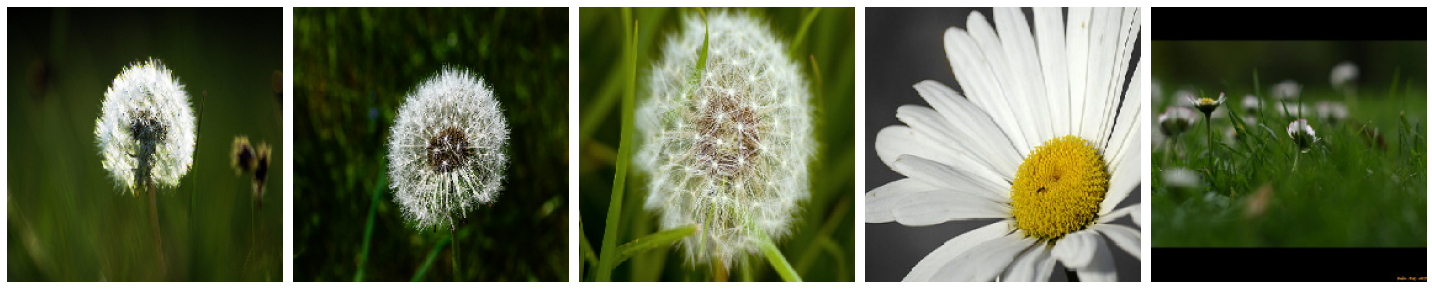

In [33]:
# Plotar imagens exemplos
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(sample_training_images[:5])

### Criando modelo

In [34]:
# Criando modelo
model = Sequential()
model.add(Conv2D(128, (3,3), padding='same', input_shape=IMAGE_SHAPE, activation='relu', name='conv_1'))
model.add(Conv2D(128, (3,3), activation='relu', name='conv_2'))
model.add(MaxPooling2D(pool_size=(2,2), name='maxpool_1'))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), padding='same', activation='relu', name='conv_3'))
model.add(Conv2D(64, (3,3), activation='relu', name='conv_4'))
model.add(MaxPooling2D(pool_size=(2,2), name='maxpool_2'))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3,3), padding='same', activation='relu', name='conv_5'))
model.add(Conv2D(32, (3,3), activation='relu', name='conv_6'))
model.add(MaxPooling2D(pool_size=(2,2), name='maxpool_3'))

model.add(Flatten())
model.add(Dense(128, activation='relu', name='dense_1'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu', name='dense_2'))
model.add(Dense(num_classes, name='output'))
model.add(Activation('softmax'))

# Compilando modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Mostrando o modelo gerado
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 224, 224, 128)     3584      
_________________________________________________________________
conv_2 (Conv2D)              (None, 222, 222, 128)     147584    
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 111, 111, 128)     0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 111, 111, 128)     0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 111, 111, 64)      73792     
_________________________________________________________________
conv_4 (Conv2D)              (None, 109, 109, 64)      36928     
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 54, 54, 64)       

### Treinando modelo

In [35]:
history = model.fit(train_data_gen,
                    steps_per_epoch=image_count_train // batch_size,
                    epochs=epochs,
                    validation_data=test_data_gen,
                    validation_steps=image_count_test // batch_size)

Epoch 1/5
103/103 [==============================] - 74s 714ms/step - loss: 1.5518 - accuracy: 0.2844 - val_loss: 1.3824 - val_accuracy: 0.4347
Epoch 2/5
103/103 [==============================] - 73s 710ms/step - loss: 1.1854 - accuracy: 0.5162 - val_loss: 1.2247 - val_accuracy: 0.5142
Epoch 3/5
103/103 [==============================] - 73s 708ms/step - loss: 0.9941 - accuracy: 0.6142 - val_loss: 1.1731 - val_accuracy: 0.5369
Epoch 4/5
103/103 [==============================] - 73s 708ms/step - loss: 0.8576 - accuracy: 0.6753 - val_loss: 1.1711 - val_accuracy: 0.5682
Epoch 5/5
103/103 [==============================] - 73s 709ms/step - loss: 0.6834 - accuracy: 0.7483 - val_loss: 1.4962 - val_accuracy: 0.5426


### Avaliando modelo

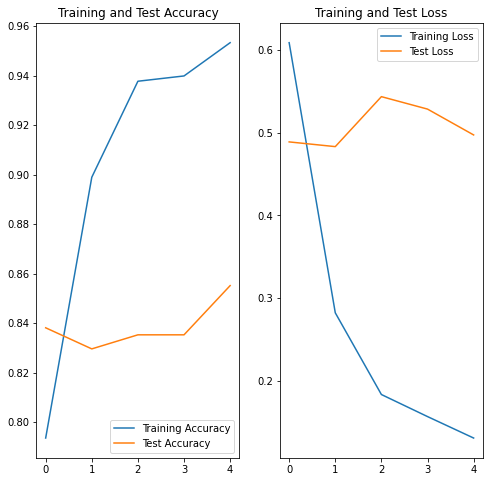

In [42]:
# Verificando a acurácia
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
# Verificando a perda loss
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Test Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Test Loss')
plt.show()

### Fazendo as predições no conjunto de teste

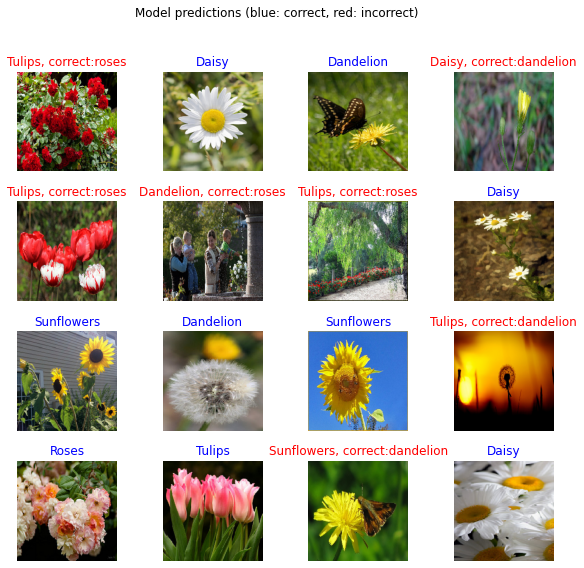

In [37]:
# Selecionando as imagens do conjunto de teste
sample_test_images, sample_test_labels = next(test_data_gen)
sample_test_labels = [CLASS_NAMES[np.argmax(sample_test_labels[i])] for i in range(batch_size)]
# Predição das imagens no modelo
predicted_class_names = model.predict(sample_test_images)
predicted_ids = [np.argmax(predicted_class_names[i]) for i in range(batch_size)]
# Encontrando as classes da predição
predicted_class_names = np.array([CLASS_NAMES[id] for id in predicted_ids])

# Plotando alguns exemplos
plt.figure(figsize=(10,9))
for n in range(16):
    plt.subplot(4,4,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(sample_test_images[n])
    if predicted_class_names[n] == sample_test_labels[n]:
        color = "blue"
        title = predicted_class_names[n].title()
    else:
        color = "red"
        title = f"{predicted_class_names[n].title()}, correct:{sample_test_labels[n]}"
    plt.title(title, color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")
plt.show()

In [38]:
# Criando modelo
hub_layer = hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_50/classification/4",
               trainable=False, arguments=dict(batch_norm_momentum=0.997))
hub_layer.build([None, 224, 224, 3])

model = Sequential()
model.add(InputLayer(input_shape=IMAGE_SHAPE))
model.add(hub_layer)
model.add(Dense(512, activation='relu', name='dense_1'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', name='dense_2'))
model.add(Dense(num_classes, name='output'))
model.add(Activation('softmax'))

# Compilando modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Mostrando o modelo gerado
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1001)              25615849  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               513024    
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
output (Dense)               (None, 5)                 645       
_________________________________________________________________
activation_5 (Activation)    (None, 5)                 0         
Total params: 26,195,182
Trainable params: 579,333
Non-trainable params: 25,615,849
____________________________________

In [39]:
history = model.fit(train_data_gen,
                    steps_per_epoch=image_count_train // batch_size,
                    epochs=epochs,
                    validation_data=test_data_gen,
                    validation_steps=image_count_test // batch_size)

Epoch 1/5
103/103 [==============================] - 22s 217ms/step - loss: 0.6085 - accuracy: 0.7935 - val_loss: 0.4887 - val_accuracy: 0.8381
Epoch 2/5
103/103 [==============================] - 21s 205ms/step - loss: 0.2823 - accuracy: 0.8989 - val_loss: 0.4830 - val_accuracy: 0.8295
Epoch 3/5
103/103 [==============================] - 21s 205ms/step - loss: 0.1836 - accuracy: 0.9377 - val_loss: 0.5433 - val_accuracy: 0.8352
Epoch 4/5
103/103 [==============================] - 21s 205ms/step - loss: 0.1570 - accuracy: 0.9398 - val_loss: 0.5283 - val_accuracy: 0.8352
Epoch 5/5
103/103 [==============================] - 21s 205ms/step - loss: 0.1311 - accuracy: 0.9533 - val_loss: 0.4971 - val_accuracy: 0.8551


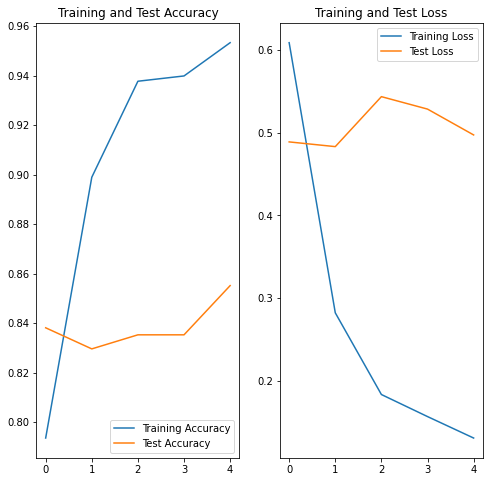

In [43]:
# Verificando a acurácia
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
# Verificando a perda loss
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Test Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Test Loss')
plt.show()

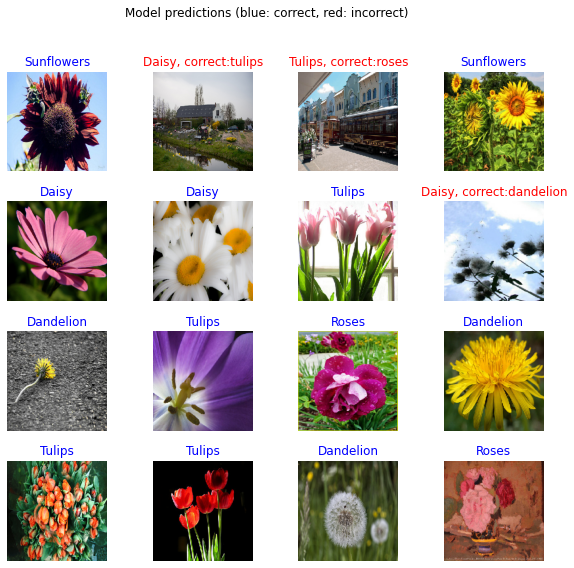

In [41]:
# Selecionando as imagens do conjunto de teste
sample_test_images, sample_test_labels = next(test_data_gen)
sample_test_labels = [CLASS_NAMES[np.argmax(sample_test_labels[i])] for i in range(batch_size)]
# Predição das imagens no modelo
predicted_class_names = model.predict(sample_test_images)
predicted_ids = [np.argmax(predicted_class_names[i]) for i in range(batch_size)]
# Encontrando as classes da predição
predicted_class_names = np.array([CLASS_NAMES[id] for id in predicted_ids])

# Plotando alguns exemplos
plt.figure(figsize=(10,9))
for n in range(16):
    plt.subplot(4,4,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(sample_test_images[n])
    if predicted_class_names[n] == sample_test_labels[n]:
        color = "blue"
        title = predicted_class_names[n].title()
    else:
        color = "red"
        title = f"{predicted_class_names[n].title()}, correct:{sample_test_labels[n]}"
    plt.title(title, color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")
plt.show()